<a href="https://colab.research.google.com/github/maniceet/places-categorization/blob/master/Places_categorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount = True)

In [2]:
#!pip install spacy-langdetect;
!pip install scikit-plot

In [0]:
#Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import gc
import nltk
import pickle
import copy
from textblob import TextBlob
import re
from bs4 import BeautifulSoup
import spacy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import scikitplot as skplt
from joblib import Parallel, delayed
import multiprocessing
nlp = spacy.load('en')
%matplotlib inline

In [0]:
#Function to evaluate model performance
def evaluate_model_preds(y_true, y_pred):
    
    # F1-Score
    f1 = f1_score(y_true, y_pred, pos_label=1, average='macro')
    print("F1: ", f1)
    print('-'*100)   
    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy: ", accuracy)
    print('-'*100)
    # Confusion Matrix
    plt.figure(figsize=(10,10))
    skplt.metrics.plot_confusion_matrix(y_true=y_true, y_pred=y_pred)
    plt.show()

    #Classification Report
    print('-'*100)
    print(classification_report(y_true, y_pred))

## Data Exploration and cleaning

In [65]:
data = pd.read_csv('/content/drive/My Drive/Temp/data.csv', encoding = 'utf-8')
print(data.shape)

(309166, 3)


In [66]:
data.head()

,Name,OtherData,Label
0,"|[""Faulkner Ridge""]",NaN,900
1,"|[""Three Brothers Pizza""]","|[""Great flavor, good price, customer service ...",100
2,"|[""Norma's Steak & Hoagie Shop""]",NaN,100
3,"|[""Breed Street Food Fair""]","|[""This place was such a gem to find and I owe...",200
4,"|[""Pegasus International. Freight""]",NaN,400


[Text(0, 0.5, 'Count of Labels'), Text(0.5, 0, 'Place Labels')]

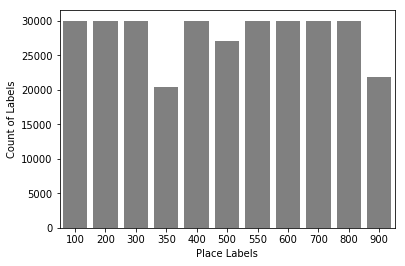

In [67]:
#Check the distribution of Classes
ax = sns.countplot(x = 'Label', data = data, color = 'grey')
ax.set(xlabel = 'Place Labels', ylabel = 'Count of Labels')

**Since the labels are quite uniformly distributed, accuracy can be used as a metric**

In [0]:
data['len_name'] = data['Name'].astype(str).apply(len)

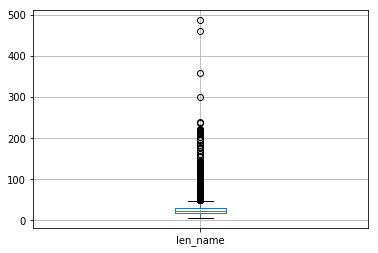

In [70]:
boxplot = data.boxplot(column = 'len_name')

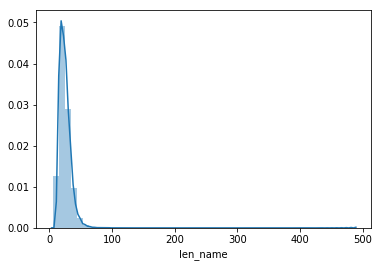

In [71]:
sns.distplot(data['len_name']);

**There are a few names which are too long, we need to take a look at them**

In [72]:
data.len_name.describe()

count    309166.000000
mean         24.782447
std           9.463144
min           6.000000
25%          18.000000
50%          23.000000
75%          30.000000
max         487.000000
Name: len_name, dtype: float64

In [73]:
print(data[data.len_name > 200].shape)
data[data.len_name > 200].head()

(20, 4)


,Name,OtherData,Label,len_name
9217,"|[""Extended Stay America - Norwalk - Stamford""...",NaN,500,210
14100,"|[""Crater Lake National Park-S Ent"",""Parco Naz...",NaN,550,215
19469,"|[""Bighorn Canyon NRA-Afterbay Station"",""Bigho...","|[""I visited Bighorn Canyon National Recreatio...",550,220
42772,"|[""Fort Bowie National Historic Site"",""Fort Bo...",NaN,550,220
49155,"|[""Boulder Junction at Depot Square Station Ga...",NaN,400,461


In [74]:
#Taking a look at some of the data points in detail
print(data.iloc[19469]['Name'])
print(data.iloc[14100]['Name'])
print(data.iloc[0]['Name'])

|["Bighorn Canyon NRA-Afterbay Station","Bighorn Canyon Nat. Erholungsgebiet","Bighorn Canyon Nat. Recreatiegebied","Site National de Bighorn Canyon","Parco Nazionale Bighorn Canyon","Area Rec. Nac. CaÃ±Ã³n Gran Cuerno"]
|["Crater Lake National Park-S Ent","Parco Naz. Crater Lake-Ingresso Sud","Crater Lake Nat. Park-Ingang Zuid","Pn de Crater Lake-EntrÃ©e Ouest","Parque Nac. Lago CrÃ¡ter Ent. Sur","Kratersee Nationalpark-S Eingang"]
|["Faulkner Ridge"]


**We can see that many data points have multiple entries in other language. The majority does have just a single entry. Keeping this in mind we will just grab the first element after splitting by ","**

In [0]:
def clean_columns(x, deep_learning = False):
  """
  Removes Additional quotations and brackets, removes caps
  Caps are retained if you want to get data for deep learning models
  """
  if not pd.isna(x):
    x = x.split(",")[0]
    x = x.replace("|[", "")
    x = x.replace("]", "")
    x = x.replace('"', "")
    if not deep_learning:
      x = x.lower()
    return x
  else:
    return np.nan 

In [0]:
data['name_lowered'] = data.Name.apply(lambda x: clean_columns(x, deep_learning = False))
data['name_caps'] = data.Name.apply(lambda x: clean_columns(x, deep_learning = True))
data['other_lowered'] = data.OtherData.apply(lambda x: clean_columns(x, deep_learning = False))
data['other_caps'] = data.OtherData.apply(lambda x: clean_columns(x, deep_learning = True))

In [0]:
#Removing special characters
def clean_text(text):
    if not pd.isna(text):
      # Remove HTML tags
      text = BeautifulSoup(text, 'html.parser').get_text()
      
      # Match alphanumerics with whitespaces
      text = re.sub(r'[^\w\s]','',text, re.UNICODE)
      text = re.sub('[^A-Za-z0-9]+', ' ', text)
      return text
    else:
      return np.nan

In [78]:
data['name_lowered'] = data.name_lowered.apply(lambda x: clean_text(x))
data['name_caps'] = data.name_caps.apply(lambda x: clean_text(x))
data['other_lowered'] = data.other_lowered.apply(lambda x: clean_text(x))
data['other_caps'] = data.other_caps.apply(lambda x: clean_text(x))

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'models'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.facebook.com/seam2seamafashionprepacademy?ref=bookmarks" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.contracostatimes.com/obituaries/ci_29588247/california-man-who-fought-fascists-1930s-spain-dies" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that docume

In [79]:
#Taking a look at cleaned data
data.head(3)

,Name,OtherData,Label,len_name,name_lowered,name_caps,other_lowered,other_caps
0,"|[""Faulkner Ridge""]",NaN,900,19,faulkner ridge,Faulkner Ridge,NaN,NaN
1,"|[""Three Brothers Pizza""]","|[""Great flavor, good price, customer service ...",100,25,three brothers pizza,Three Brothers Pizza,great flavor,Great flavor
2,"|[""Norma's Steak & Hoagie Shop""]",NaN,100,32,normas steak hoagie shop,Normas Steak Hoagie Shop,NaN,NaN


In [80]:
print(data['name_lowered'].astype(str).apply(len).describe())

#Taking a look at the same examples again
print(data.iloc[19469]['name_lowered'])
print(data.iloc[14100]['name_lowered'])
print(data.iloc[0]['name_lowered'])

count    309166.000000
mean         18.902075
std           8.352723
min           1.000000
25%          13.000000
50%          18.000000
75%          24.000000
max         100.000000
Name: name_lowered, dtype: float64
bighorn canyon nraafterbay station
crater lake national parks ent
faulkner ridge


**we see the 75th percentile go down from 30 to 24 and the max to 100, which means that we have removed the multiple language names**

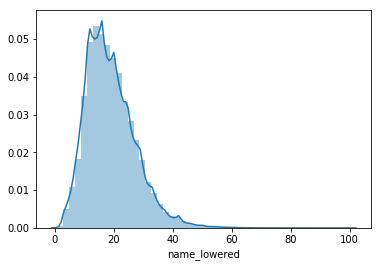

In [81]:
#Checking distribution on len name again
sns.distplot(data['name_lowered'].astype(str).apply(len));

In [0]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(data['name_lowered'], 20)

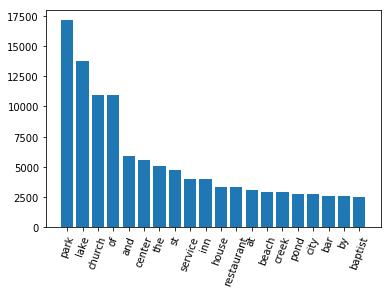

In [83]:
plt.bar(range(len(common_words)), [val[1] for val in common_words], align='center')
plt.xticks(range(len(common_words)), [val[0] for val in common_words])
plt.xticks(rotation=70)
plt.show()
# There seems to be many parks and lakes in our data 

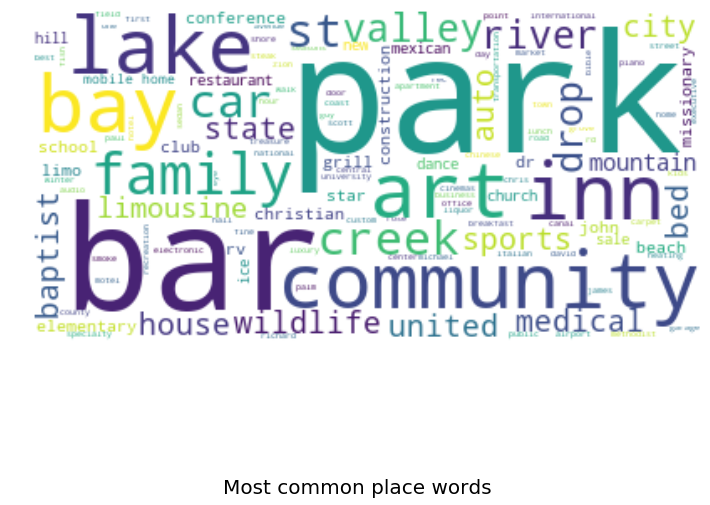

In [84]:
# A quick visualization to see the most common words in places
from wordcloud import WordCloud, STOPWORDS 

def generate_wordcloud(no_places = 50, title = None):
    wordcloud_text = ''.join([x for x in data['name_lowered'][:no_places]])
    wordcloud = WordCloud(relative_scaling = 1.0,
                          background_color='white',
                          max_words=200,
                          max_font_size=100,                          
                          stopwords = STOPWORDS # set or space-separated string
                          ).generate(wordcloud_text)
    
    fig = plt.figure(1, figsize=(12,18))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
        
        
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

generate_wordcloud(no_places = 1000, title = 'Most common place words')

In [0]:
#Saving data for further use
data.drop(['len_name'], axis = 1, inplace = True)
data.to_csv("data_mod.csv", index = False)

In [0]:
#Splitting data into Train and Test
#Test data will be evaluated at the end
train, test = train_test_split(data, test_size = 0.2, stratify = data['Label'], random_state = 17)

In [87]:
print(train.shape)
print(test.shape)

(247332, 7)
(61834, 7)


## Performance using Classical NLP Techniques

### Performance on char level Ngrams

In [0]:
vectorizer = TfidfVectorizer(analyzer='char_wb',  ngram_range = (3, 6), max_features = 200000)
X = vectorizer.fit_transform(train['name_lowered'])

In [129]:
print(X.shape)
y = train['Label']

(247332, 200000)


In [30]:
baseline_cv_char = GridSearchCV(MultinomialNB(), {'alpha': np.arange(0.5, 2, 0.1)},
                           cv=5, scoring = 'accuracy', n_jobs = -1)
baseline_cv_char.fit(X,y)
print(baseline_cv_char.best_params_)
print(f"Baseline score is {baseline_cv_char.best_score_}")

{'alpha': 0.7}
Baseline score is 0.6598943929616872


In [31]:
X_train, X_val, y_train, y_val = train_test_split(X,y, train_size = 0.8, 
                                                  random_state = 17, stratify = y)
print(X_train.shape)
print(X_val.shape)

(197865, 200000)
(49467, 200000)


In [32]:
nb_clf_char = MultinomialNB(alpha = 0.7)
nb_clf_char.fit(X_train, y_train)

MultinomialNB(alpha=0.7, class_prior=None, fit_prior=True)

In [0]:
with open('/content/drive/My Drive/Temp/Models/naive_bayes_char.model', 'wb') as f:
  pickle.dump(nb_clf_char, f)

F1:  0.6571175336159311
----------------------------------------------------------------------------------------------------
Accuracy:  0.6575899084237977
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

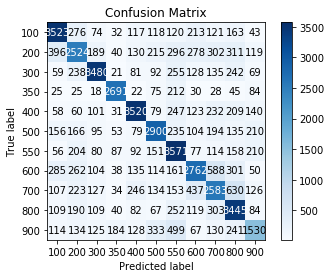

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         100       0.72      0.73      0.73      4800
         200       0.59      0.53      0.55      4800
         300       0.77      0.72      0.75      4800
         350       0.83      0.83      0.83      3255
         400       0.76      0.73      0.75      4800
         500       0.68      0.67      0.67      4327
         550       0.60      0.74      0.66      4800
         600       0.64      0.58      0.60      4800
         700       0.55      0.54      0.54      4800
         800       0.59      0.72      0.65      4800
         900       0.57      0.44      0.50      3485

    accuracy                           0.66     49467
   macro avg       0.66      0.66      0.66     49467
weighted avg       0.66      0.66      0.66     49467



In [34]:
preds_nb = nb_clf_char.predict(X_val)
evaluate_model_preds(y_val, preds_nb)

**The baseline naive bayes model does really well on most of the classes, but it struggles on classes 200, 600, 700, 900, let us take a look at whether other models can overcome this**

In [35]:
%%time
#Looking at RandomForest classifier performance
gc.collect()
rf_clf_char = RandomForestClassifier(n_estimators= 100, min_samples_split= 2, n_jobs = -1)
rf_clf_char.fit(X_train, y_train)

CPU times: user 2h 53min, sys: 5.04 s, total: 2h 53min 5s
Wall time: 43min 46s


In [0]:
with open('/content/drive/My Drive/Temp/Models/random_forest_char.model', 'wb') as f:
  pickle.dump(rf_clf_char, f)

Hyper-parameter tuning has not been done as to save time

F1:  0.704861724601205
----------------------------------------------------------------------------------------------------
Accuracy:  0.699860513069319
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

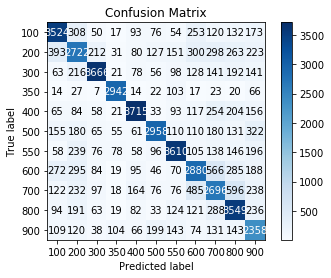

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         100       0.72      0.73      0.73      4800
         200       0.59      0.57      0.58      4800
         300       0.83      0.76      0.80      4800
         350       0.88      0.90      0.89      3255
         400       0.82      0.77      0.80      4800
         500       0.79      0.68      0.73      4327
         550       0.78      0.75      0.77      4800
         600       0.63      0.60      0.61      4800
         700       0.56      0.56      0.56      4800
         800       0.63      0.74      0.68      4800
         900       0.55      0.68      0.61      3485

    accuracy                           0.70     49467
   macro avg       0.71      0.71      0.70     49467
weighted avg       0.71      0.70      0.70     49467



In [41]:
preds_rf = rf_clf_char.predict(X_val)
evaluate_model_preds(y_val, preds_rf)

**Better results than naive bayes, maybe with more hyper-parameter tuning, we can etch out one or two more percentage points , moving to see how xgboost performs** 

In [0]:
#Using Xgboost
import xgboost as xgb
xgb_clf_char = xgb.XGBClassifier(n_estimators=100, max_depth = 15, 
                            objective='multi:softprob', learning_rate = 0.3,
                            colsample_bylevel=0.8,colsample_bytree=0.8, verbosity = 1,
                            n_jobs = -1)

In [0]:
xgb_clf_char.fit(X_train, y_train, eval_metric = 'merror', early_stopping_rounds= 10,
            eval_set=[(X_train, y_train), (X_val, y_val)])

In [0]:
with open('/content/drive/My Drive/Temp/Models/xgboost_char.model', 'wb') as f:
  pickle.dump(xgb_clf_char, f)

F1:  0.7099562140372282
----------------------------------------------------------------------------------------------------
Accuracy:  0.7040451209897507
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

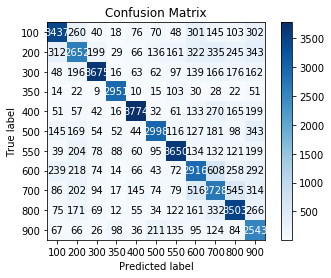

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         100       0.76      0.72      0.74      4800
         200       0.63      0.55      0.59      4800
         300       0.84      0.77      0.80      4800
         350       0.89      0.91      0.90      3255
         400       0.86      0.79      0.82      4800
         500       0.80      0.69      0.74      4327
         550       0.79      0.76      0.77      4800
         600       0.60      0.61      0.60      4800
         700       0.54      0.57      0.55      4800
         800       0.66      0.73      0.69      4800
         900       0.51      0.73      0.60      3485

    accuracy                           0.70     49467
   macro avg       0.72      0.71      0.71     49467
weighted avg       0.71      0.70      0.71     49467



In [45]:
preds_xgb = xgb_clf_char.predict(X_val)

evaluate_model_preds(y_val, preds_xgb)

**We got an accuracy of 65.5% with naive bayes, 70% with Random Forest and xgboost. Each of the model struggled with the class 200, 600, 700 and 900.Let's see what word level ngrams can do**

### Performance on word level Ngrams

**Places do not have that many words in them, so we will keep our n_gram range to 1,3 only**

In [0]:
vectorizer_word = TfidfVectorizer(analyzer='word',  ngram_range = (1, 3), max_features = 200000)
X = vectorizer_word.fit_transform(train['name_lowered'])

In [27]:
X.shape

(247332, 200000)

In [0]:
y = train['Label']

#### Take a look at a simple model to evaluate baseline score

In [0]:
baseline_cv_word = GridSearchCV(MultinomialNB(), {'alpha': np.arange(0.5, 5, 0.1)}, 
                           cv=5, scoring = 'accuracy', n_jobs = -1)


In [52]:
baseline_cv_word.fit(X,y)
print(baseline_cv_word.best_params_)
print(f"Baseline score is {baseline_cv_word.best_score_}")

{'alpha': 1.1999999999999997}
Baseline score is 0.6812220011967719


In [31]:
X_train, X_val, y_train, y_val = train_test_split(X,y, train_size = 0.9, 
                                                  random_state = 17, stratify = y)
print(X_train.shape)
print(X_val.shape)

(222598, 200000)
(24734, 200000)


In [0]:
nb_clf_word = MultinomialNB(alpha= 1.2).fit(X_train, y_train)

In [0]:
with open('/content/drive/My Drive/Temp/Models/nb_word.model', 'wb') as f:
  pickle.dump(nb_clf_word, f)

F1:  0.6760149178476347
----------------------------------------------------------------------------------------------------
Accuracy:  0.680925042451686
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

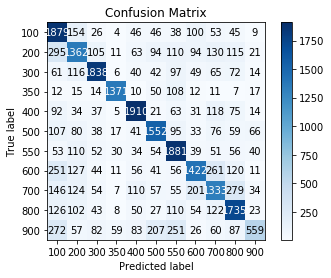

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         100       0.57      0.78      0.66      2400
         200       0.60      0.57      0.58      2400
         300       0.79      0.77      0.78      2400
         350       0.90      0.84      0.87      1627
         400       0.78      0.80      0.79      2400
         500       0.71      0.72      0.71      2164
         550       0.66      0.78      0.71      2400
         600       0.69      0.59      0.64      2400
         700       0.58      0.56      0.57      2400
         800       0.65      0.72      0.69      2400
         900       0.69      0.32      0.44      1743

    accuracy                           0.68     24734
   macro avg       0.69      0.68      0.68     24734
weighted avg       0.69      0.68      0.68     24734



In [59]:
preds_nb = nb_clf_word.predict(X_val)
evaluate_model_preds(y_val, preds_nb)

**Performs better when compared to char level model. The categories 200, 600, 700 and 900 are still not performing well**

In [60]:
#Looking at RandomForest classifier performance
gc.collect()
rf_clf_word = RandomForestClassifier(n_estimators= 100, min_samples_split= 2, n_jobs = -1)
rf_clf_word.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
with open('/content/drive/My Drive/Temp/Models/rf_word.model', 'wb') as f:
  pickle.dump(rf_clf_word, f)

F1:  0.6956169080906255
----------------------------------------------------------------------------------------------------
Accuracy:  0.6902644133581305
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

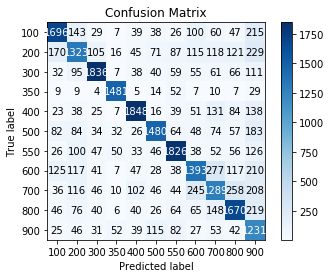

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         100       0.75      0.71      0.73      2400
         200       0.62      0.55      0.58      2400
         300       0.82      0.77      0.79      2400
         350       0.88      0.91      0.90      1627
         400       0.82      0.77      0.79      2400
         500       0.77      0.68      0.72      2164
         550       0.77      0.76      0.76      2400
         600       0.65      0.58      0.61      2400
         700       0.57      0.54      0.55      2400
         800       0.66      0.70      0.68      2400
         900       0.42      0.71      0.53      1743

    accuracy                           0.69     24734
   macro avg       0.70      0.70      0.70     24734
weighted avg       0.70      0.69      0.69     24734



In [62]:
preds_rf = rf_clf_word.predict(X_val)
evaluate_model_preds(y_val, preds_rf)

**The Random Forest performs marginally better than the naive bayes, had comparable results to its char level model**

#### Creating xgboost Classifier to check for score

In [0]:
#We are increasing the n_estimators, max_depth and lr
xgb_clf_word = xgb.XGBClassifier(n_estimators=100, max_depth = 15, 
                            objective='multi:softprob', learning_rate = 0.3,
                            colsample_bylevel=0.8, colsample_bytree=0.8, verbosity = 0,
                            n_jobs = -1)

In [32]:
xgb_clf_word.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
            eval_metric = 'merror', early_stopping_rounds= 10)

[76]	validation_0-merror:0.29702	validation_1-merror:0.340584
[77]	validation_0-merror:0.296364	validation_1-merror:0.340382
[78]	validation_0-merror:0.295865	validation_1-merror:0.34026
[79]	validation_0-merror:0.295349	validation_1-merror:0.34018
[80]	validation_0-merror:0.294841	validation_1-merror:0.339775
[81]	validation_0-merror:0.294374	validation_1-merror:0.339371
[82]	validation_0-merror:0.293974	validation_1-merror:0.339411
[83]	validation_0-merror:0.293466	validation_1-merror:0.339209
[84]	validation_0-merror:0.292909	validation_1-merror:0.338724
[85]	validation_0-merror:0.292446	validation_1-merror:0.338926
[86]	validation_0-merror:0.291885	validation_1-merror:0.338603
[87]	validation_0-merror:0.291512	validation_1-merror:0.338481
[88]	validation_0-merror:0.291112	validation_1-merror:0.338522
[89]	validation_0-merror:0.290623	validation_1-merror:0.338481
[90]	validation_0-merror:0.290209	validation_1-merror:0.338401
[91]	validation_0-merror:0.289724	validation_1-merror:0.33

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=0)

In [0]:
with open('/content/drive/My Drive/Temp/Models/xgboost_word.model', 'wb') as f:
  pickle.dump(xgb_clf_word, f)

F1:  0.6786127962098745
----------------------------------------------------------------------------------------------------
Accuracy:  0.6637422171909113
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

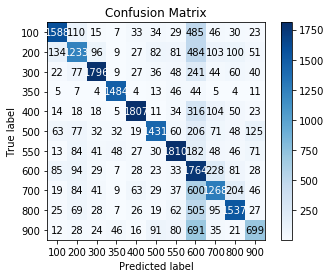

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         100       0.80      0.66      0.73      2400
         200       0.66      0.51      0.58      2400
         300       0.85      0.75      0.79      2400
         350       0.89      0.91      0.90      1627
         400       0.87      0.75      0.81      2400
         500       0.80      0.66      0.72      2164
         550       0.78      0.75      0.77      2400
         600       0.32      0.73      0.45      2400
         700       0.62      0.53      0.57      2400
         800       0.70      0.64      0.67      2400
         900       0.61      0.40      0.48      1743

    accuracy                           0.66     24734
   macro avg       0.72      0.66      0.68     24734
weighted avg       0.71      0.66      0.68     24734



In [34]:
gc.collect()
preds_xgb = xgb_clf_word.predict(X_val)

evaluate_model_preds(y_val, preds_xgb)

**An accuracy score of 70% with just tf-idf models is great, we have gone from a null accuracy of 9% to 70%, next let us see what adding more features and Deep Learning can achieve**

### Using Other Data to Augment ML Model
Let us create a combined feature using both Name and Other Data and see how the model performs and whether using Other Data helps us in better predictions

In [42]:
train.isna().sum()

Name                  0
OtherData        176085
Label                 0
name_lowered          0
name_caps             0
other_lowered    176085
other_caps       176085
dtype: int64

In [43]:
train.fillna('no comment', inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [47]:
train['combined_lowered'] = '[name] '+train['name_lowered'] +' [endname] ' +  \
                            '[otherdata] ' + train['other_lowered'] + ' [endotherdata]'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [48]:
train['combined_caps'] = '[name] '+train['name_caps'] +' [endname] ' +  \
                            '[otherdata] ' + train['other_caps'] + ' [endotherdata]'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
vectorizer_comb = TfidfVectorizer(analyzer='word',  ngram_range = (1, 3), max_features = 400000)
X = vectorizer_comb.fit_transform(train['name_lowered'])
print(X.shape)


(247332, 400000)


In [0]:
y = train['Label']

In [51]:
baseline_cv_comb = GridSearchCV(MultinomialNB(), {'alpha': np.arange(0.5, 2, 0.1)},
                           cv=5, scoring = 'accuracy', n_jobs = -1)
baseline_cv_comb.fit(X,y)
print(baseline_cv_comb.best_params_)
print(f"Baseline score is {baseline_cv_comb.best_score_}")

{'alpha': 1.0999999999999999}
Baseline score is 0.6788082415538629


In [52]:
#Splitting data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X,y, train_size = 0.9, 
                                                  random_state = 17, stratify = y)
print(X_train.shape)
print(X_val.shape)

(222598, 400000)
(24734, 400000)


In [54]:
nb_clf_comb = MultinomialNB(alpha = 1.1)
nb_clf_comb.fit(X_train, y_train)

MultinomialNB(alpha=1.1, class_prior=None, fit_prior=True)

In [0]:
with open('/content/drive/My Drive/Temp/Models/nb_comb.model', 'wb') as f:
  pickle.dump(nb_clf_comb, f)

F1:  0.6730902556112388
----------------------------------------------------------------------------------------------------
Accuracy:  0.6785800921808037
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

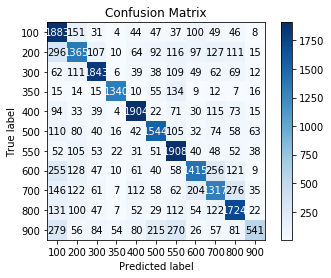

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         100       0.57      0.78      0.66      2400
         200       0.60      0.57      0.59      2400
         300       0.78      0.77      0.77      2400
         350       0.91      0.82      0.86      1627
         400       0.78      0.79      0.79      2400
         500       0.70      0.71      0.71      2164
         550       0.64      0.80      0.71      2400
         600       0.69      0.59      0.64      2400
         700       0.59      0.55      0.57      2400
         800       0.66      0.72      0.69      2400
         900       0.70      0.31      0.43      1743

    accuracy                           0.68     24734
   macro avg       0.69      0.67      0.67     24734
weighted avg       0.69      0.68      0.67     24734



In [56]:
preds_nb = nb_clf_comb.predict(X_val)
evaluate_model_preds(y_val, preds_nb)

**Even with other data added, the model struggles on classes 200, 600, 700 and 900**

In [0]:
#We are directly training xgboost and not random forest as 
#xgboost had comparable performance to random forest
xgb_clf_comb = xgb.XGBClassifier(n_estimators=100, max_depth = 15, 
                            objective='multi:softprob', learning_rate = 0.3,
                            reg_lambda = 2,
                            colsample_bylevel=0.8, colsample_bytree=0.8, verbosity = 0,
                            n_jobs = -1)

In [58]:
xgb_clf_comb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
            eval_metric = 'merror', early_stopping_rounds= 10)

[97]	validation_0-merror:0.295888	validation_1-merror:0.338805
[98]	validation_0-merror:0.295461	validation_1-merror:0.338845
[99]	validation_0-merror:0.295155	validation_1-merror:0.338886


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=0)

In [0]:
with open('/content/drive/My Drive/Temp/Models/xgboost_comb.model', 'wb') as f:
  pickle.dump(xgb_clf_comb, f)

F1:  0.6772906446825748
----------------------------------------------------------------------------------------------------
Accuracy:  0.6611951160346082
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

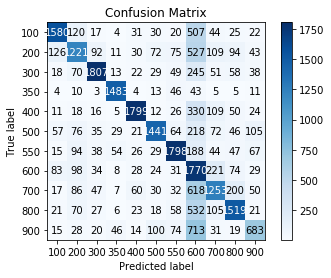

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         100       0.81      0.66      0.73      2400
         200       0.65      0.51      0.57      2400
         300       0.85      0.75      0.80      2400
         350       0.89      0.91      0.90      1627
         400       0.87      0.75      0.81      2400
         500       0.80      0.67      0.73      2164
         550       0.79      0.75      0.77      2400
         600       0.31      0.74      0.44      2400
         700       0.61      0.52      0.56      2400
         800       0.71      0.63      0.67      2400
         900       0.62      0.39      0.48      1743

    accuracy                           0.66     24734
   macro avg       0.72      0.66      0.68     24734
weighted avg       0.72      0.66      0.68     24734



In [60]:
gc.collect()
preds_xgb = xgb_clf_comb.predict(X_val)

evaluate_model_preds(y_val, preds_xgb)

**We see that adding other data does not help our classifiers both in terms of accuracy and the f1-score on classes 200, 600, 700 and 900 are still not up to the mark
Apart from naive bayes, rf and xgboost does well on char level models**

## Using Deep Learning methods

In [0]:
#In case system crashes
#data = pd.read_csv('data_mod.csv')

In [0]:
#Not using combined data as it did not help us in the classification
dl_data = train.filter(items = ['name_caps', 'Label'])
dl_data.dropna(inplace = True)
dl_data.rename(columns = {'name_caps':'text',
                          'Label': 'label'}, inplace = True)

In [0]:
train_df, valid_df = train_test_split(dl_data, test_size = 0.1, stratify = dl_data['label'],
                                      random_state = 17)

In [28]:
import os
path = os.getcwd()
print(path)
print(train_df.shape)
train_df.head(2)

/content
(222598, 2)


,text,label
230359,Lakeside Terrace RV Park,700
38594,Hollywood Terrace,700


### Keras

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.models import load_model

# fix random seed for reproducibility
np.random.seed(17)

In [0]:
X = dl_data.text.values
y = dl_data.label

In [166]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 100000
# Max number of words in each place
MAX_SEQUENCE_LENGTH = 256
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
                      lower=True)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88070 unique tokens.


In [167]:
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (247332, 256)


In [0]:
y = pd.get_dummies(y).values

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 17,
                                                    stratify = y)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(222598, 256) (222598, 11)
(24734, 256) (24734, 11)


In [36]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(500, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.3))
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 100)          10000000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 256, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 500)               1202000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                5511      
Total params: 11,207,511
Trainable params: 11,207,511
Non-trainable params: 0
_____________________________________________________

In [37]:
epochs = 3
batch_size = 1024

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 200338 samples, validate on 22260 samples
Epoch 1/3
200338/200338 [==============================] - 540s 3ms/step - loss: 1.5606 - acc: 0.5086 - val_loss: 1.0308 - val_acc: 0.6886
Epoch 2/3
200338/200338 [==============================] - 533s 3ms/step - loss: 0.9236 - acc: 0.7227 - val_loss: 0.9528 - val_acc: 0.7128
Epoch 3/3
200338/200338 [==============================] - 532s 3ms/step - loss: 0.7418 - acc: 0.7825 - val_loss: 0.9642 - val_acc: 0.7124


In [38]:
model.save("/content/drive/My Drive/Temp/Models/keras_model.h5")
print("Saved model to disk")

Saved model to disk


In [84]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

24734/24734 [==============================] - 156s 6ms/step
Test set
  Loss: 0.995
  Accuracy: 0.700


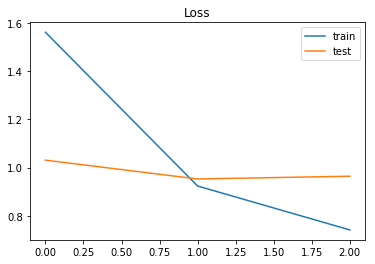

In [39]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

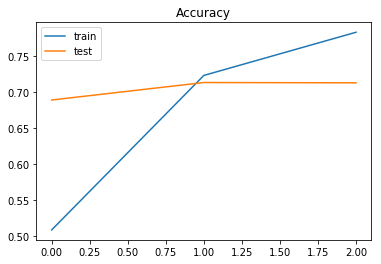

In [40]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

### ULMFit (Fastai)

We are not using other data as we found that it does not give us a boost when it comes to predictions and they are mostly empty

In [0]:
from functools import reduce
from fastai.text import *
from fastai.callbacks import *
from fastai import *
from fastai.metrics import *

In [0]:
torch.cuda.empty_cache()

In [0]:
bs = 128
# Language model data
data_lm = TextLMDataBunch.from_df(path = os.getcwd(),train_df = train_df, valid_df = valid_df, text_cols= 'text', label_cols= 'label')

data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [47]:
data_lm.show_batch(1)

idx,text
0,xxmaj bowman xxmaj island xxbos xxmaj contemporary xxmaj art xxmaj gallery xxbos xxmaj cora xxbos xxmaj fairfield xxmaj lake xxbos xxmaj hawaii xxmaj beach xxmaj homes xxbos xxmaj emerald xxmaj tower xxbos xxup kenwood xxmaj depot xxbos xxmaj xxunk xxmaj phillips xxmaj inn xxbos xxmaj golden xxmaj gulf xxup vip xxmaj limousines xxbos xxmaj tom and xxmaj jerrys xxmaj apartments xxbos xxmaj house of xxmaj beauty xxbos xxmaj manuels xxmaj


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [49]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-02
Min loss divided by 10: 5.25E-02


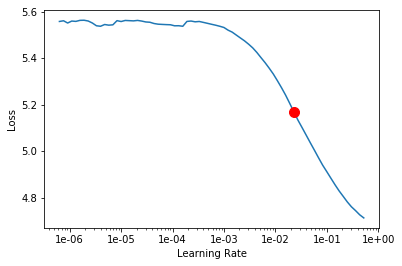

In [50]:
learn.recorder.plot(skip_end=15, suggestion = True)

In [51]:
learn.fit_one_cycle(1, max_lr = 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.369063,3.094553,0.553290,02:39


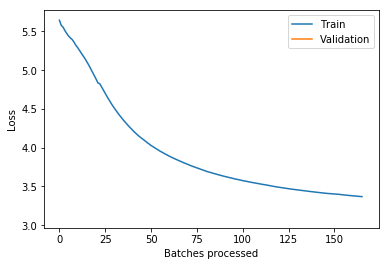

In [52]:
learn.recorder.plot_losses()

In [0]:
learn.unfreeze()

In [54]:
learn.fit_one_cycle(4, slice(2e-2/(2.6**4), 2e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.095417,3.021956,0.559252,03:10
1,3.031608,2.982255,0.564368,03:10
2,2.769167,2.996316,0.566013,03:10
3,2.498628,3.084191,0.564033,03:10


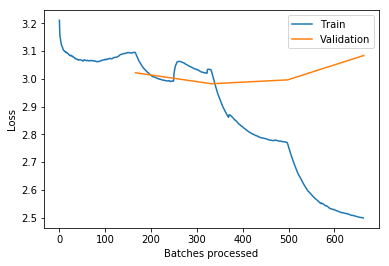

In [55]:
learn.recorder.plot_losses()

In [0]:
learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned');

In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
#Training Classifier
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = os.getcwd(), train_df = train_df, 
          valid_df = valid_df, text_cols= 'text', label_cols= 'label', 
          classes = [100, 200, 300, 350, 400, 500, 550, 600, 700, 800, 900], bs=128)

In [60]:
data_clas.save('data_clas.pkl')
data_clas = load_data(path, 'data_clas.pkl', bs=bs)
data_clas.show_batch()

text,target
xxbos xxmaj pelican xxmaj watch 208 2 s xxmaj beach xxmaj front xxmaj pool xxmaj elevator xxmaj wifi xxmaj sleeps 4 2 xxmaj br xxmaj con,500
xxbos 3br 2ba xxmaj downtown xxmaj austin xxmaj house with xxmaj pool xxmaj walk xxmaj to xxmaj zilker xxmaj sleep 10 by xxmaj redawning,500
xxbos xxmaj quiet 3 xxmaj bedroom with xxmaj balcony and xxmaj splash xxmaj pool 3 xxmaj br xxmaj cabin by xxmaj redawning,500
xxbos 200 xxmaj feet xxmaj east of xxmaj villa xxmaj rd xxup nw and xxmaj hampton xxmaj ln xxup nw,400
xxbos 1 xxmaj br xxmaj home at xxmaj snowbird xxmaj landing xxmaj sleeps 3 xxmaj wifi by xxmaj redawning,500


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc');
learn.freeze()

In [62]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-02
Min loss divided by 10: 1.74E-02


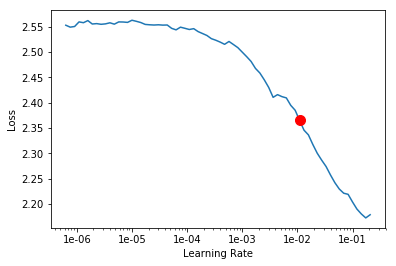

In [63]:
learn.recorder.plot(suggestion= True, skip_end=15)

In [64]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.431630,1.292099,0.584054,01:05


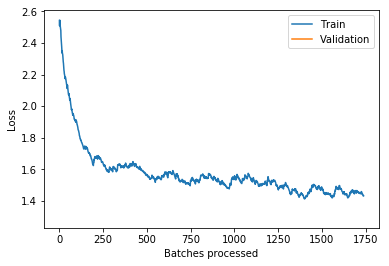

In [65]:
learn.recorder.plot_losses()

In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [68]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.224529,1.066479,0.657961,01:15
1,1.070224,1.000163,0.684564,01:17
2,1.065627,0.971817,0.693741,01:13


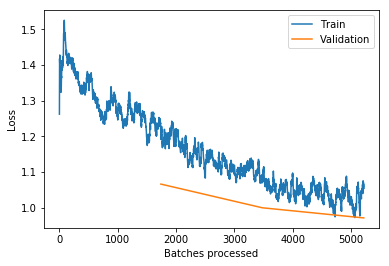

In [69]:
learn.recorder.plot_losses()

In [0]:
learn.save('second')

In [0]:
learn.load('second');

epoch,train_loss,valid_loss,accuracy,time
0,1.055125,0.966391,0.697784,02:13
1,0.931302,0.920291,0.711814,02:07
2,0.879756,0.896527,0.717353,02:10


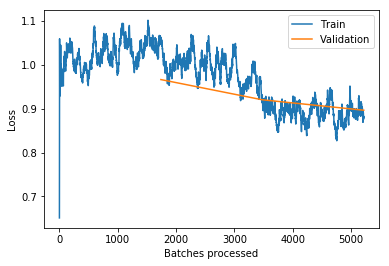

In [72]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn.recorder.plot_losses()

In [0]:
learn.save('third')

In [0]:
learn.load('third');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 8.32E-07


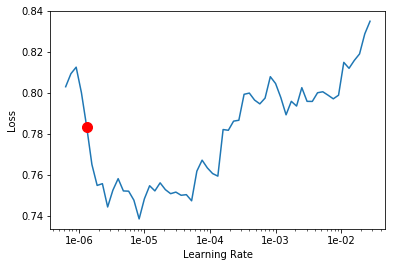

In [75]:
learn.lr_find()
learn.recorder.plot(suggestion= True, skip_end=15)

epoch,train_loss,valid_loss,accuracy,time
0,0.862173,0.894760,0.717676,02:49
1,0.816896,0.897090,0.717717,02:46
2,0.834647,0.894026,0.725803,02:47


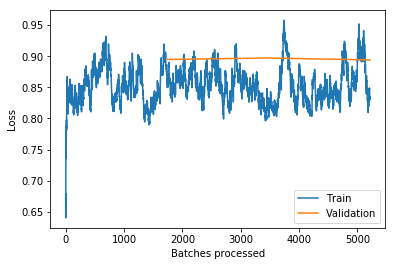

In [76]:
learn.freeze_to(-4)
learn.fit_one_cycle(3, slice(1e-6/(2.6**4),1e-6), moms=(0.8,0.7))
learn.recorder.plot_losses()

In [0]:
learn.save('fourth')

In [0]:
learn.load('fourth');

In [0]:
learn.save('fine_tuned_classifier')

In [0]:
learn.export('/content/drive/My Drive/Temp/Models/ulmfit_model.pkl')

In [81]:
cat_map = learn.data.c2i
cat_map

{100: 0,
 200: 1,
 300: 2,
 350: 3,
 400: 4,
 500: 5,
 550: 6,
 600: 7,
 700: 8,
 800: 9,
 900: 10}

In [0]:
preds_ulmfit = [int(str(learn.predict(i)[0])) for i in valid_df['text']]

In [83]:
preds_ulmfit[:5]

[350, 900, 900, 700, 500]

F1:  0.7301498044607629
----------------------------------------------------------------------------------------------------
Accuracy:  0.7258025390151209
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

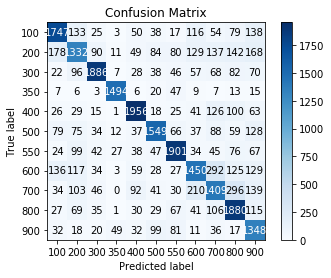

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         100       0.76      0.73      0.74      2400
         200       0.64      0.56      0.60      2400
         300       0.85      0.79      0.81      2400
         350       0.93      0.92      0.92      1627
         400       0.82      0.81      0.82      2400
         500       0.78      0.72      0.75      2164
         550       0.80      0.79      0.79      2400
         600       0.68      0.60      0.64      2400
         700       0.60      0.59      0.59      2400
         800       0.66      0.78      0.71      2400
         900       0.57      0.77      0.65      1743

    accuracy                           0.73     24734
   macro avg       0.73      0.73      0.73     24734
weighted avg       0.73      0.73      0.73     24734



In [85]:
evaluate_model_preds(valid_df['label'], preds_ulmfit)

### Using BERT

In [48]:
!pip install pytorch_pretrained_bert

In [0]:
import torch
import torch.optim as optim
from pytorch_pretrained_bert import BertTokenizer 

In [0]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)


config = Config(
    testing=False,
    bert_model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=4,
    use_fp16=False,
    bs=128,
    discriminative=False,
    max_seq_len=256,
)

In [0]:
bert_tok = BertTokenizer.from_pretrained(config.bert_model_name)

In [0]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [0]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, 
                              max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

In [0]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [0]:
databunch = TextDataBunch.from_df(".", train_df, valid_df, 
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="text",
                  label_cols="label",
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )


In [94]:
databunch.show_batch(2)

text,target
[CLS] i ##gles ##ia del di ##os vivo col ##una y app ##oll ##o de la ve ##rda ##d la luz del mundo [SEP],300
[CLS] beautiful executive home in a gate ##d community 4 br home by red ##aw ##ning [SEP],500


In [0]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=11)

In [0]:
learner = Learner(
    databunch, bert_model,
    metrics=[accuracy]
)
learner.callbacks.append(ShowGraph(learner))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-04
Min loss divided by 10: 1.74E-04


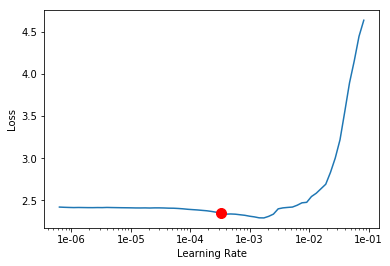

In [97]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.882570,0.856887,0.735587,12:13


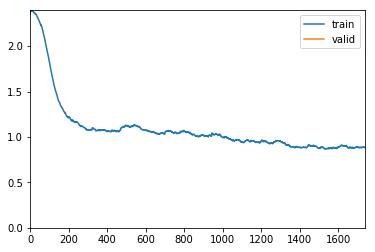

In [98]:
learner.fit_one_cycle(1, max_lr=3e-4)

In [0]:
learner.save('first_bert')

In [0]:
learner.load('first_bert');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-05
Min loss divided by 10: 6.31E-08


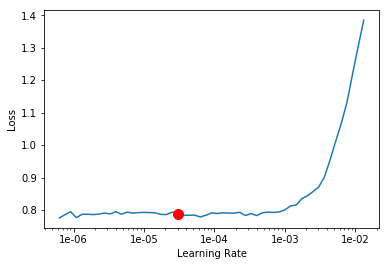

In [102]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.773714,0.841103,0.743107,12:31


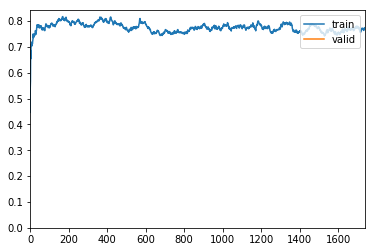

In [103]:
learner.freeze_to(-2)
learner.fit_one_cycle(1, 3e-5, moms=(0.8,0.7))

In [0]:
learner.save('second_bert')

In [0]:
learner.load('second_bert');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 6.31E-06


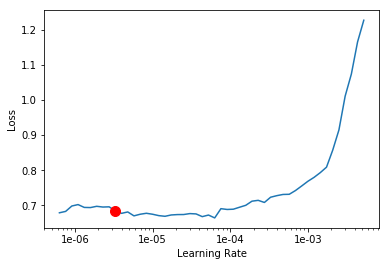

In [106]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.703228,0.846336,0.743147,12:19


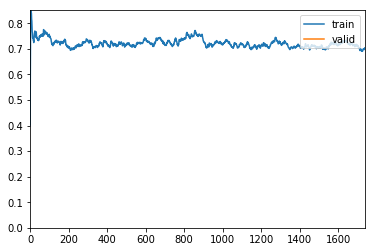

In [107]:
learner.freeze_to(-3)
learner.fit_one_cycle(1, 3e-6, moms=(0.8,0.7))

In [0]:
learner.save('third_bert')

In [0]:
learner.load('third_bert');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 6.31E-08


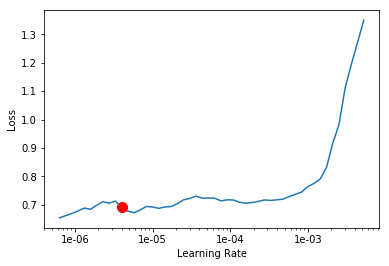

In [113]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.732382,0.847179,0.743026,11:59
1,0.697554,0.847862,0.743471,12:07


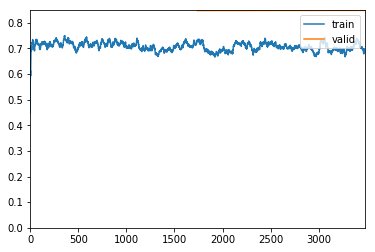

In [114]:
learner.freeze_to(-4)
learner.fit_one_cycle(2, 4e-6, moms=(0.8,0.7))

In [0]:
learner.export('/content/drive/My Drive/Temp/Models/bert_model.pkl')

In [116]:
cat_map = learner.data.c2i
cat_map

{100: 0,
 200: 1,
 300: 2,
 350: 3,
 400: 4,
 500: 5,
 550: 6,
 600: 7,
 700: 8,
 800: 9,
 900: 10}

In [0]:
preds_bert = [int(str(learner.predict(i)[0])) for i in valid_df['text']]

F1:  0.7479311543583556
----------------------------------------------------------------------------------------------------
Accuracy:  0.7432683755154847
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

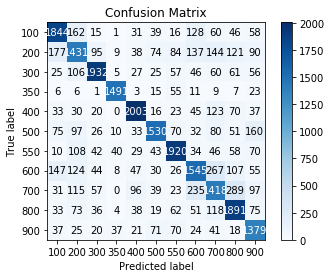

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         100       0.76      0.77      0.77      2400
         200       0.63      0.60      0.61      2400
         300       0.84      0.81      0.82      2400
         350       0.93      0.92      0.92      1627
         400       0.85      0.83      0.84      2400
         500       0.80      0.71      0.75      2164
         550       0.80      0.80      0.80      2400
         600       0.68      0.64      0.66      2400
         700       0.60      0.59      0.60      2400
         800       0.70      0.79      0.74      2400
         900       0.66      0.79      0.72      1743

    accuracy                           0.74     24734
   macro avg       0.75      0.75      0.75     24734
weighted avg       0.75      0.74      0.74     24734



In [118]:
evaluate_model_preds(valid_df['label'], preds_bert)

## Evaluating Models on Test Set

In [0]:
#Loading Models
#From classical models we are using xgboost char level and rf_char level
#as they gave the best overall performance on validation

#Xgboost model
with open('/content/drive/My Drive/Temp/Models/xgboost_char.model', 'rb') as f:
  xgb_clf_char = pickle.load(f)
#Rf model
with open('/content/drive/My Drive/Temp/Models/random_forest_char.model', 'rb') as f:
  rf_clf_char = pickle.load(f)

In [0]:
#Keras
keras_model = load_model('/content/drive/My Drive/Temp/Models/keras_model.h5')

In [0]:
#ulmfitmodel
#Loading Trained Model
learn_ulmfit = load_learner('/content/drive/My Drive/Temp/Models/', 'ulmfit_model.pkl')

In [0]:
#bertmodel
#Loading Trained Model
learn_bert = load_learner('/content/drive/My Drive/Temp/Models/', 'bert_model.pkl')

In [57]:
print(test.shape)
test.head(2)

(61834, 7)


,Name,OtherData,Label,name_lowered,name_caps,other_lowered,other_caps
253608,"|[""Beach Harbor Limo""]","|[""This place was late to pick us up and the d...",400,beach harbor limo,Beach Harbor Limo,this place was late to pick us up and the driv...,This place was late to pick us up and the driv...
270588,"|[""Stockholm""]",NaN,900,stockholm,Stockholm,NaN,NaN


**A clear increase can be seen using deep learning models, both ulmfit and bert outperform the classical models by around 4-5% and does well even on categories that they were struggling on espescially bert on 900**

In [0]:
#Prepping Test data for predictions
vectorizer_test = TfidfVectorizer(analyzer='char_wb',  ngram_range = (3, 6), max_features = 200000)
vectorizer_test = vectorizer_test.fit(train['name_lowered'])
ml_test = vectorizer_test.transform(test['name_lowered'])

F1:  0.7048995262878301
----------------------------------------------------------------------------------------------------
Accuracy:  0.7004560597729405
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

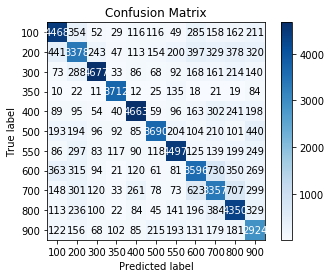

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         100       0.73      0.74      0.74      6000
         200       0.60      0.56      0.58      6000
         300       0.84      0.78      0.81      6000
         350       0.87      0.91      0.89      4069
         400       0.82      0.78      0.80      6000
         500       0.80      0.68      0.74      5409
         550       0.78      0.75      0.76      6000
         600       0.62      0.60      0.61      6000
         700       0.56      0.56      0.56      6000
         800       0.63      0.72      0.67      6000
         900       0.54      0.67      0.60      4356

    accuracy                           0.70     61834
   macro avg       0.71      0.71      0.70     61834
weighted avg       0.71      0.70      0.70     61834



In [89]:
#Testing random Forest Model on test Data
pred_rf_test = rf_clf_char.predict(ml_test)
evaluate_model_preds(test['Label'], pred_rf_test)

F1:  0.7100807837508273
----------------------------------------------------------------------------------------------------
Accuracy:  0.7046932108548695
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

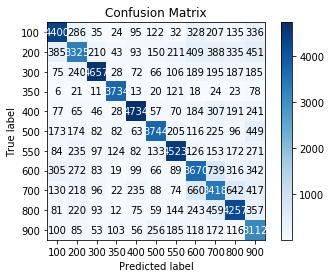

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         100       0.76      0.73      0.74      6000
         200       0.65      0.55      0.60      6000
         300       0.85      0.78      0.81      6000
         350       0.89      0.92      0.90      4069
         400       0.84      0.79      0.82      6000
         500       0.79      0.69      0.74      5409
         550       0.79      0.75      0.77      6000
         600       0.61      0.61      0.61      6000
         700       0.54      0.57      0.56      6000
         800       0.66      0.71      0.68      6000
         900       0.50      0.71      0.59      4356

    accuracy                           0.70     61834
   macro avg       0.71      0.71      0.71     61834
weighted avg       0.71      0.70      0.71     61834



In [90]:
#Testing xgboost model on test Data
pred_xgb_test = xgb_clf_char.predict(ml_test)
evaluate_model_preds(test['Label'], pred_xgb_test)

**We get close to validation results, with average results on classes 200, 600, 700 and 900 as expected by ml models**

In [0]:
dl_test_data = test.filter(items = ['name_caps', 'Label'])
dl_test_data.dropna(inplace = True)
dl_test_data.rename(columns = {'name_caps':'text',
                          'Label': 'label'}, inplace = True)

In [0]:
#Testing using Keras
X_keras = dl_test_data.text.values
y_keras = dl_test_data.label

In [171]:
test_keras = tokenizer.texts_to_sequences(X_keras)
test_keras = pad_sequences(test_keras, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', test_keras.shape)

Shape of data tensor: (61834, 256)


In [0]:
y_keras = pd.get_dummies(y_keras).values

In [173]:
accr_test = model.evaluate(test_keras, y_keras)

61834/61834 [==============================] - 402s 7ms/step


In [176]:
print('Accuracy on test data with Keras is {}'.format(accr_test[1]))

Accuracy on test data with Keras is 0.6987579648717662


F1:  0.7254563785162684
----------------------------------------------------------------------------------------------------
Accuracy:  0.721
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

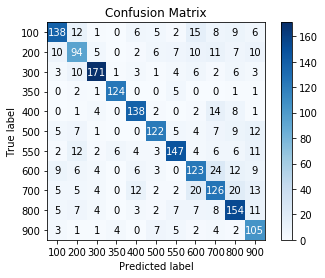

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         100       0.77      0.68      0.72       202
         200       0.60      0.58      0.59       162
         300       0.86      0.81      0.84       210
         350       0.92      0.93      0.92       134
         400       0.79      0.81      0.80       170
         500       0.80      0.71      0.75       172
         550       0.80      0.72      0.76       203
         600       0.64      0.63      0.63       196
         700       0.60      0.60      0.60       209
         800       0.66      0.74      0.70       208
         900       0.58      0.78      0.66       134

    accuracy                           0.72      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.72      0.72      2000



In [98]:
#Testing on ULMFit
#Testing for only 2000 samples as prediction with ulmfit takes some time
preds_ulmfit  = [int(str(learn_ulmfit.predict(i)[0])) for i in dl_test_data['text'][:2000] ]
evaluate_model_preds(dl_test_data['label'][:2000], preds_ulmfit)

F1:  0.7488912645108177
----------------------------------------------------------------------------------------------------
Accuracy:  0.744
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

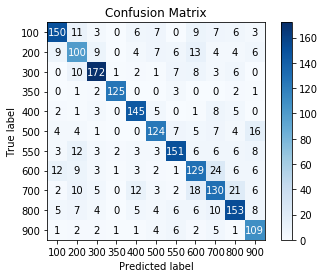

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         100       0.80      0.74      0.77       202
         200       0.60      0.62      0.61       162
         300       0.83      0.82      0.82       210
         350       0.96      0.93      0.95       134
         400       0.80      0.85      0.83       170
         500       0.78      0.72      0.75       172
         550       0.80      0.74      0.77       203
         600       0.65      0.66      0.66       196
         700       0.64      0.62      0.63       209
         800       0.71      0.74      0.73       208
         900       0.67      0.81      0.73       134

    accuracy                           0.74      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.74      0.74      2000



In [99]:
#Testing on BERT
#Testing for only 2000 samples as prediction with bert takes some time
preds_bert  = [int(str(learn_bert.predict(i)[0])) for i in dl_test_data['text'][:2000] ]
evaluate_model_preds(dl_test_data['label'][:2000], preds_bert)

Bert outperforms all models along with doing well on category 900

**Let us ensemble our two best deep learning models, ulmfit and bert and see if we can beat bert's standalone accuracy**

In [0]:
#Ensemble predictions
labels = [100,200,300,350,400,500,550,600,700,800,900]
preds_ensembled = []
#Testing only on 20000 samples as predictions take time
#we can expect similar results on entire test set
for i in range(20000):  
  dl_text = test.iloc[i]['name_caps']
  bert_pred = int(str(learn_bert.predict(dl_text)[0]))
  if bert_pred == 900:
    preds_ensembled.append(bert_pred)
  else:
    ulmfit_pred = np.array(learn_ulmfit.predict(dl_text)[2])
    bert_pred = np.array(learn_bert.predict(dl_text)[2])
    ensembled_pred = np.mean([bert_pred, ulmfit_pred], axis = 0)
    class_index = np.argmax(ensembled_pred)
    class_name = labels[class_index]
    preds_ensembled.append(class_name)


F1:  0.756535219529163
----------------------------------------------------------------------------------------------------
Accuracy:  0.75225
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

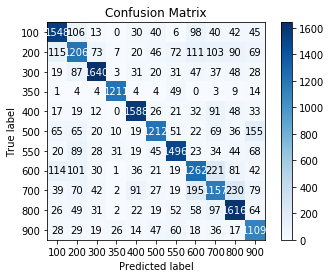

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         100       0.78      0.79      0.78      1968
         200       0.66      0.63      0.65      1912
         300       0.86      0.82      0.84      1991
         350       0.94      0.93      0.93      1303
         400       0.85      0.84      0.84      1887
         500       0.80      0.70      0.75      1724
         550       0.80      0.79      0.79      1897
         600       0.68      0.65      0.67      1928
         700       0.61      0.59      0.60      1951
         800       0.71      0.79      0.75      2036
         900       0.65      0.79      0.71      1403

    accuracy                           0.75     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.75      0.75      0.75     20000



In [142]:
evaluate_model_preds(test.iloc[:20000]['Label'], preds_ensembled)

**The ensemble of two of our best models, gave us an accuracy of 75%, which is clearly better than standalone accuracy of either model.  If a single model has to be used, we would go with bert, otherwise an ensemble of ulmfit and bert will be chosen**